In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from core import events

In [10]:
epl = events(league=8)

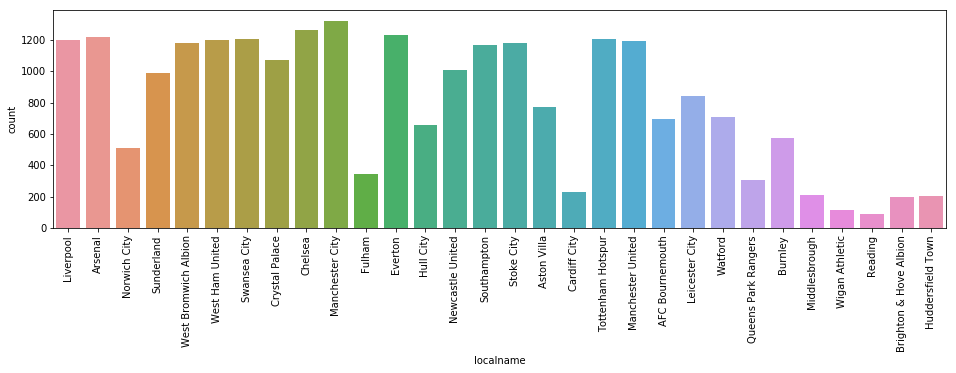

In [167]:
plt.figure(figsize=(16,4))
sns.countplot(epl['localname'])
plt.xticks(rotation='vertical');

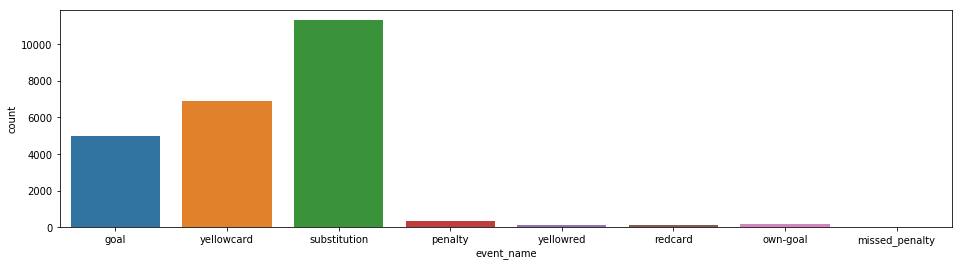

In [11]:
plt.figure(figsize=(16,4))
sns.countplot(epl['event_name'])

In [122]:
s2015 = epl[epl['season'] == '2015/2016']

#game result only (removing duplicates for all events. Another option is to query fixtures only w/o events)
gs2015 = s2015[['fixture_id','localname', 'localteam_score','visitorteam_score','visitorname','outcome','season']].drop_duplicates()

In [123]:
hometeam = 'Tottenham Hotspur'
awayteam = 'Everton'

### Attack Strenght

In [124]:
average_home = np.sum(gs2015['localteam_score'])/len(gs2015)
average_away = np.sum(gs2015['visitorteam_score'])/len(gs2015)

print ('Premier League 2015/2016')
print ('Home: ', average_home, '\t\tAway :', average_away)

Premier League 2015/2016
Home:  1.49604221636 		Away : 1.20844327177


In [125]:
tot_att_home = np.sum(gs2015[gs2015['localname']==hometeam]['localteam_score'])/len(gs2015[gs2015['localname']==hometeam])/average_home
tot_att_away = np.sum(gs2015[gs2015['visitorname']==hometeam]['visitorteam_score'])/len(gs2015[gs2015['visitorname']==hometeam])/average_away

print (hometeam)
print ('Home: ', tot_att_home, '\t\tAway :', tot_att_away)

Tottenham Hotspur
Home:  1.23131903834 		Away : 1.48080900942


In [126]:
eve_att_home = np.sum(gs2015[gs2015['localname']==awayteam]['localteam_score'])/len(gs2015[gs2015['localname']==awayteam])/average_home
eve_att_away = np.sum(gs2015[gs2015['visitorname']==awayteam]['visitorteam_score'])/len(gs2015[gs2015['visitorname']==awayteam])/average_away

print (awayteam)
print ('Home: ', eve_att_home, '\t\tAway :', eve_att_away)

Everton
Home:  1.23131903834 		Away : 1.04527694783


### Defense Strenght

In [127]:
tot_def_home = np.sum(gs2015[gs2015['localname']==hometeam]['visitorteam_score'])/len(gs2015[gs2015['localname']==hometeam])/average_away
tot_def_away = np.sum(gs2015[gs2015['visitorname']==hometeam]['localteam_score'])/len(gs2015[gs2015['visitorname']==hometeam])/average_home

print (hometeam)
print ('Home: ', tot_def_home, '\t\tAway :', tot_def_away)

Tottenham Hotspur
Home:  0.653298092393 		Away : 0.703610879049


In [129]:
eve_def_home = np.sum(gs2015[gs2015['localname']==awayteam]['visitorteam_score'])/len(gs2015[gs2015['localname']==awayteam])/average_away
eve_def_away = np.sum(gs2015[gs2015['visitorname']==awayteam]['localteam_score'])/len(gs2015[gs2015['visitorname']==awayteam])/average_home

print (awayteam)
print ('Home: ', eve_def_home, '\t\tAway :', eve_def_away)

Everton
Home:  1.30659618479 		Away : 0.879513598812


### Expected Goals

In [130]:
#goals tottenham will score:
tot_goals = tot_att_home * eve_def_away * average_home

#goals everton will score;
eve_goals = eve_att_home * tot_def_away * average_away

In [131]:
print ('Expected Result: ', hometeam,tot_goals,eve_goals,awayteam)

Expected Result:  Tottenham Hotspur 1.62015662939 1.04695835804 Everton


### Poisson Distribution

In [132]:
import scipy
from sklearn.utils.extmath import cartesian
import pandas as pd

In [133]:
poisson = scipy.stats.distributions.poisson
goals = [0,1,2,3,4,5]
tot_prob = poisson.pmf(goals, tot_goals)
eve_prob = poisson.pmf(goals, eve_goals)

tot_df = pd.DataFrame([tot_prob,goals], index=['tot_prob','tot_score']).transpose()
eve_df = pd.DataFrame([eve_prob,goals], index=['eve_prob','eve_score']).transpose()

In [134]:
all_results = pd.DataFrame(cartesian([tot_prob, eve_prob]), columns = ['tot_prob','eve_prob']).merge(
        tot_df, on='tot_prob', how='inner'
    ).merge(
        eve_df, on='eve_prob', how='inner'
    )

all_results['prob'] = all_results['tot_prob']*all_results['eve_prob']
all_results.sort_values('prob', ascending=False).reset_index(drop=True)

prob_matrix = all_results.pivot('tot_score', 'eve_score', 'prob')

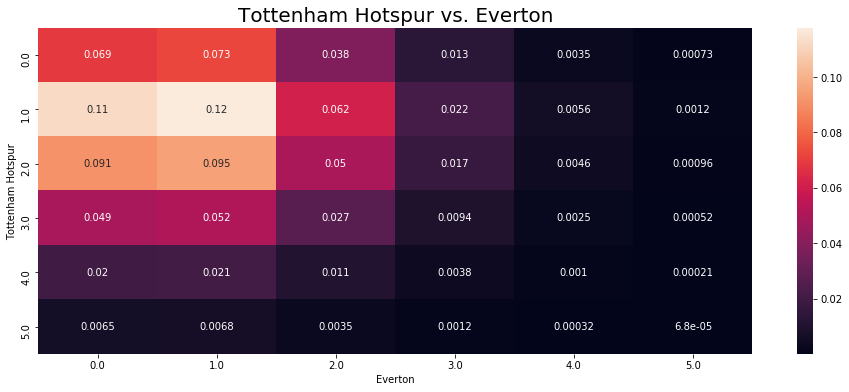

In [142]:
plt.figure(figsize=(16,6))
sns.heatmap(prob_matrix, annot=True)
plt.title('{0} vs. {1}'.format(hometeam, awayteam), fontsize=20)
plt.xlabel(awayteam)
plt.ylabel(hometeam);

In [ ]:
#1/prob_matrix to check decimal odds

In [171]:
##Transforming into a function

def probability_matrix(events, hometeam, awayteam, season='2016/2017'):
    """
    :events: dataframe with fixture/events data
    :return: probability matrix with all combinations
    """
    events_season = events[events['season'] == season]
    dedup_events = events_season[[
            'fixture_id','localname', 'localteam_score','visitorteam_score',
            'visitorname','outcome','season'
        ]].drop_duplicates()
    
    average_home = np.sum(dedup_events['localteam_score'])/len(dedup_events)
    average_away = np.sum(dedup_events['visitorteam_score'])/len(dedup_events)
    
    #attack strength
    home_att_home = np.sum(dedup_events[dedup_events['localname']==hometeam]['localteam_score'])/len(dedup_events[dedup_events['localname']==hometeam])/average_home
    home_att_away = np.sum(dedup_events[dedup_events['visitorname']==hometeam]['visitorteam_score'])/len(dedup_events[dedup_events['visitorname']==hometeam])/average_away

    away_att_home = np.sum(dedup_events[dedup_events['localname']==awayteam]['localteam_score'])/len(dedup_events[dedup_events['localname']==awayteam])/average_home
    away_att_away = np.sum(dedup_events[dedup_events['visitorname']==awayteam]['visitorteam_score'])/len(dedup_events[dedup_events['visitorname']==awayteam])/average_away

    #defense strength
    home_def_home = np.sum(dedup_events[dedup_events['localname']==hometeam]['visitorteam_score'])/len(dedup_events[dedup_events['localname']==hometeam])/average_away
    home_def_away = np.sum(dedup_events[dedup_events['visitorname']==hometeam]['localteam_score'])/len(dedup_events[dedup_events['visitorname']==hometeam])/average_home

    away_def_home = np.sum(dedup_events[dedup_events['localname']==awayteam]['visitorteam_score'])/len(dedup_events[dedup_events['localname']==awayteam])/average_away
    away_def_away = np.sum(dedup_events[dedup_events['visitorname']==awayteam]['localteam_score'])/len(dedup_events[dedup_events['visitorname']==awayteam])/average_home

    #expected goals
    #goals home will score:
    home_goals = home_att_home * away_def_away * average_home

    #goals away will score;
    away_goals = away_att_away * home_def_home * average_away
    
    #poisson distrib.
    poisson = scipy.stats.distributions.poisson
    goals = [0,1,2,3,4,5]
    home_prob = poisson.pmf(goals, home_goals)
    away_prob = poisson.pmf(goals, away_goals)

    home_df = pd.DataFrame([home_prob,goals], index=['home_prob','home_score']).transpose()
    away_df = pd.DataFrame([away_prob,goals], index=['away_prob','away_score']).transpose()
    
    #probability matrix with all scores combinations
    all_results = pd.DataFrame(cartesian([home_prob, away_prob]), columns = ['home_prob','away_prob']).merge(
        home_df, on='home_prob', how='inner'
    ).merge(
        away_df, on='away_prob', how='inner'
    )

    all_results['prob'] = all_results['home_prob']*all_results['away_prob']

    prob_matrix = all_results.pivot('home_score', 'away_score', 'prob')
    
    #plot
    plt.figure(figsize=(16,6))
    sns.heatmap(prob_matrix, annot=True)
    plt.title('{0} vs. {1} - {2} Season'.format(hometeam, awayteam, season), fontsize=20)
    plt.xlabel(awayteam)
    plt.ylabel(hometeam)
    plt.show()
    
    return 1/prob_matrix

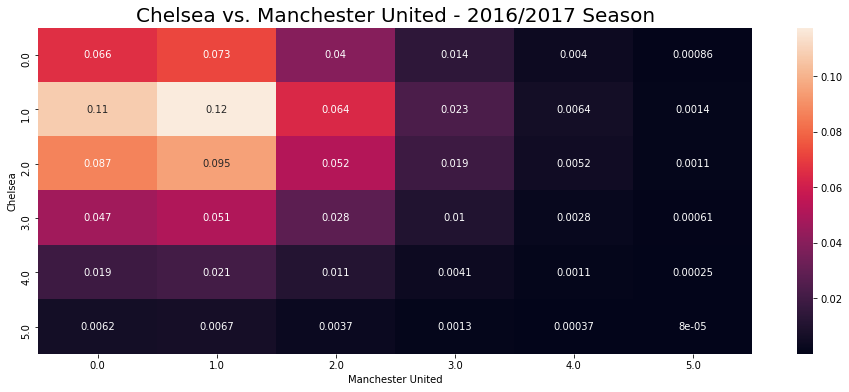

In [172]:
hometeam = 'Chelsea'
awayteam = 'Manchester United'

probability_matrix(epl, hometeam=hometeam, awayteam=awayteam, season='2016/2017');